In [4]:
# pip install yfinance --user


In [5]:
# !pip install yahoofinancials

In [6]:
# pip3 install yfinance

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools

In [8]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from numpy.linalg import eig
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [9]:
import yfinance as yf

In [10]:
ticker = yf.Ticker('BTC-USD')
BTC_df = ticker.history(period="max")


# EDA on the data
We should drop Dividends and stock splits 

In [11]:
BTC_df

Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2022-02-14  42157.398438  42775.777344  41681.957031  42586.917969   
2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2022-02-17  43937.070312  44132.972656  40249.371094  40538.011719   
2022-02-18  40475.714844  40922.371094  39696.546875  40038.492188   

                 Volume  Dividends  Stock Splits  
Date                                              
2014-09-17     21056800          0             0  
2014-09-18     34483200          0             0  
2014-09-19     37919700          0             0  
2014-09-20     36863600          0             0  
2014-09-21     26580100          0             0  
...                 ...        ...           ...  
2022-02-14  20827783012          0             0  
2022-02-15  22721659051          0             0  
2022-02-16  19792547657          0             0  
2022-02-17  26246662813          0             0  
2022-02-18  23452907520          0             0  

[2712 rows x 7 columns]

The data is an index, i need to reset it and make it as a column

In [12]:
BTC_df.reset_index(inplace=True)

Text(0.5, 1.0, 'Bitcoin Price')

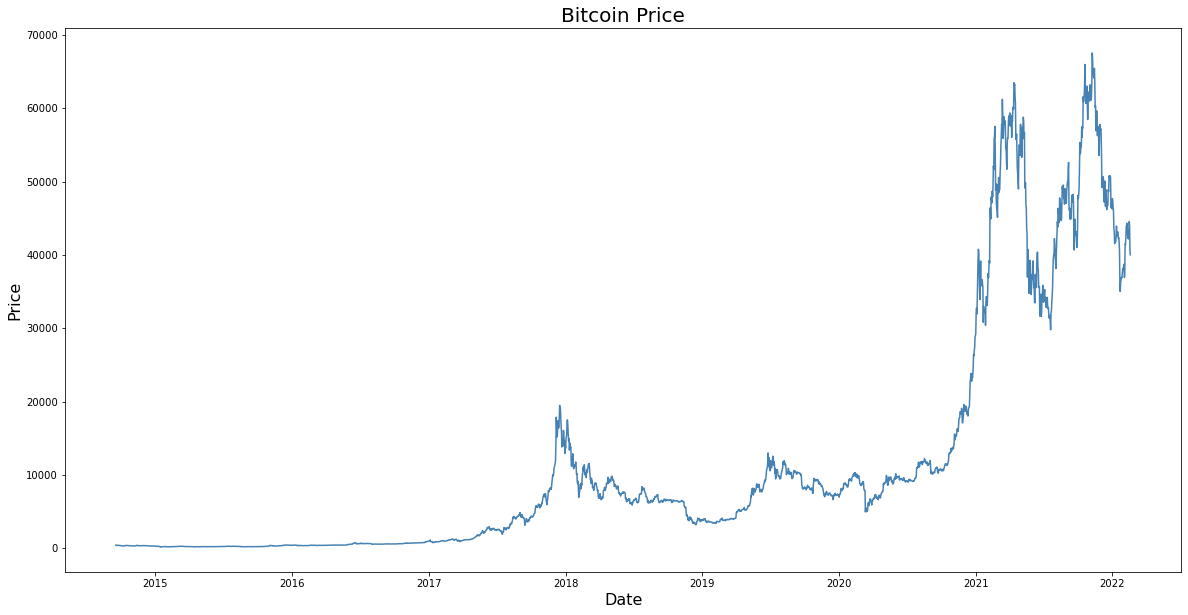

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(BTC_df['Date'],BTC_df['Close'], color='steelblue')
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
ax.set_title('Bitcoin Price', fontsize = 20)

# Volumn chart 

Text(0.5, 1.0, 'Bitcoin Volume')

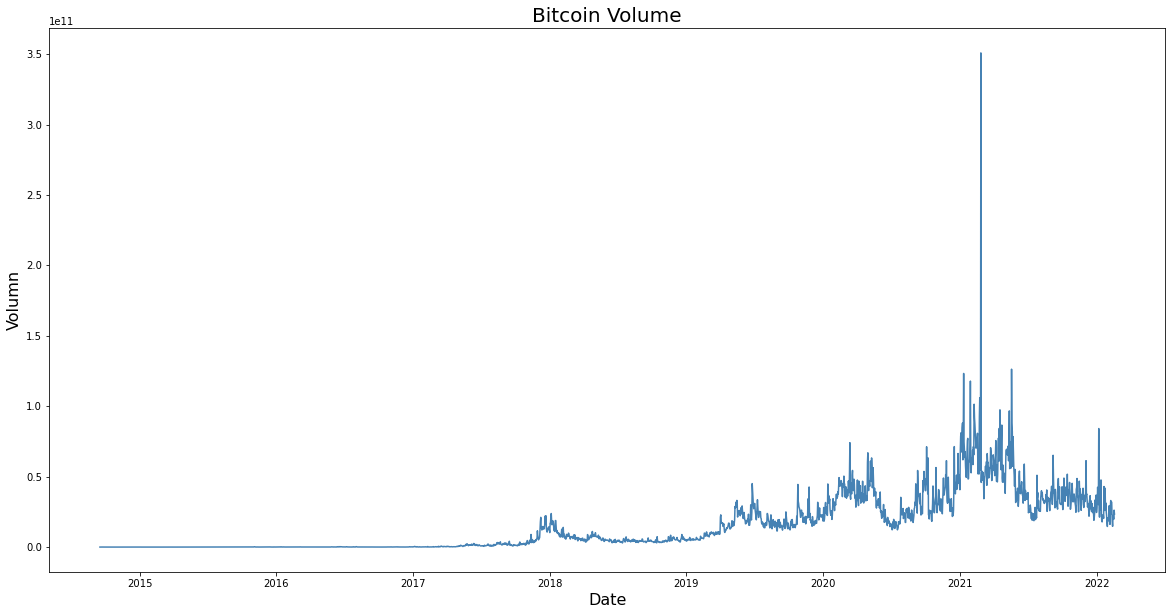

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(BTC_df['Date'],BTC_df['Volume'], color='steelblue')
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Volumn', fontsize = 16)
ax.set_title('Bitcoin Volume', fontsize = 20)


In [15]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 0 to 2711
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2712 non-null   datetime64[ns]
 1   Open          2712 non-null   float64       
 2   High          2712 non-null   float64       
 3   Low           2712 non-null   float64       
 4   Close         2712 non-null   float64       
 5   Volume        2712 non-null   int64         
 6   Dividends     2712 non-null   int64         
 7   Stock Splits  2712 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 169.6 KB


In [16]:
BTC_df.drop(['Dividends', 'Stock Splits'], axis = 1, inplace= True)

In [17]:
BTC_df

Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
2707 2022-02-14  42157.398438  42775.777344  41681.957031  42586.917969   
2708 2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2709 2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2710 2022-02-17  43937.070312  44132.972656  40249.371094  40538.011719   
2711 2022-02-18  40475.714844  40922.371094  39696.546875  40038.492188   

           Volume  
0        21056800  
1        34483200  
2        37919700  
3        36863600  
4        26580100  
...           ...  
2707  20827783012  
2708  22721659051  
2709  19792547657  
2710  26246662813  
2711  23452907520  

[2712 rows x 6 columns]

In order to know whether the day have gains/losses, i will check whether the close price is higher or lower than the open prices. 
Higher than closing price is 1
Lower than closing price is 0 

In [18]:
outcome = BTC_df['Close'] > BTC_df['Open']
BTC_df['Profit_or_loss'] = outcome
BTC_df['Profit_or_loss'] = BTC_df['Profit_or_loss'].replace(True, 1)
BTC_df['Profit_or_loss'] = BTC_df['Profit_or_loss'].replace(False, 0)
BTC_df

Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
2707 2022-02-14  42157.398438  42775.777344  41681.957031  42586.917969   
2708 2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2709 2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2710 2022-02-17  43937.070312  44132.972656  40249.371094  40538.011719   
2711 2022-02-18  40475.714844  40922.371094  39696.546875  40038.492188   

           Volume  Profit_or_loss  
0        21056800               0  
1        34483200               0  
2        37919700               0  
3        36863600               1  
4        26580100               0  
...           ...             ...  
2707  20827783012               1  
2708  22721659051               1  
2709  19792547657               0  
2710  26246662813               0  
2711  23452907520               0  

[2712 rows x 7 columns]

In [19]:
BTC_df.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Profit_or_loss    0
dtype: int64

In [20]:
BTC_df.duplicated().sum()

0

In [21]:
# BTC_df['previous_day_closing_price'] = BTC_df['Close'].shift(1)

In [22]:
# BTC_df

# Feature selection on the following column, This is an example for me to try out using prediction for 1 day

# I need to split my training data and testing data so they don't overlap. when i do my prediction against the test data. we lets check whether it matches with the actual data 

In [23]:
BTC_df

Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
2707 2022-02-14  42157.398438  42775.777344  41681.957031  42586.917969   
2708 2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2709 2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2710 2022-02-17  43937.070312  44132.972656  40249.371094  40538.011719   
2711 2022-02-18  40475.714844  40922.371094  39696.546875  40038.492188   

           Volume  Profit_or_loss  
0        21056800               0  
1        34483200               0  
2        37919700               0  
3        36863600               1  
4        26580100               0  
...           ...             ...  
2707  20827783012               1  
2708  22721659051               1  
2709  19792547657               0  
2710  26246662813               0  
2711  23452907520               0  

[2712 rows x 7 columns]

# Feature Selection

In [24]:
BTC_df

Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
2707 2022-02-14  42157.398438  42775.777344  41681.957031  42586.917969   
2708 2022-02-15  42586.464844  44667.218750  42491.035156  44575.203125   
2709 2022-02-16  44578.277344  44578.277344  43456.691406  43961.859375   
2710 2022-02-17  43937.070312  44132.972656  40249.371094  40538.011719   
2711 2022-02-18  40475.714844  40922.371094  39696.546875  40038.492188   

           Volume  Profit_or_loss  
0        21056800               0  
1        34483200               0  
2        37919700               0  
3        36863600               1  
4        26580100               0  
...           ...             ...  
2707  20827783012               1  
2708  22721659051               1  
2709  19792547657               0  
2710  26246662813               0  
2711  23452907520               0  

[2712 rows x 7 columns]

In [25]:
feat = BTC_df.columns[1:6]
X = BTC_df[feat]
y = BTC_df['Profit_or_loss']

In [26]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)


# Split my training data into different time frame

In [27]:
training_days = pd.date_range(start="2014-09-17",end="2021-12-31")
num_training_days = len(training_days)
num_training_days

2663

In [28]:
X_train = scaled_X[:num_training_days]
y_train = y[:num_training_days]
X_test = scaled_X[num_training_days:]
y_test = y[num_training_days:]

In [29]:
X_train

array([[-0.67308228, -0.67372919, -0.67393333, -0.67424698, -0.73346327],
       [-0.67364164, -0.67441372, -0.67645393, -0.67628998, -0.73279248],
       [-0.67567663, -0.67616981, -0.67828563, -0.67813112, -0.73262079],
       ...,
       [ 2.25654408,  2.20931008,  2.25895386,  2.1819575 ,  0.76676286],
       [ 2.18614151,  2.19480295,  2.24990285,  2.22750871,  0.5987585 ],
       [ 2.22830889,  2.23065446,  2.23449386,  2.17337004,  1.1127375 ]])

In [30]:
y_train

0       0
1       0
2       0
3       1
4       0
       ..
2658    0
2659    0
2660    0
2661    1
2662    0
Name: Profit_or_loss, Length: 2663, dtype: int64

In [31]:
X_test

array([[ 2.17503012e+00,  2.19161735e+00,  2.26453052e+00,
         2.25910250e+00,  4.93650140e-01],
       [ 2.26008852e+00,  2.19489016e+00,  2.30097298e+00,
         2.23788664e+00,  6.61962619e-01],
       [ 2.23912908e+00,  2.17246311e+00,  2.23552034e+00,
         2.18279014e+00,  9.17763960e-01],
       [ 2.18416884e+00,  2.16615997e+00,  2.23016731e+00,
         2.14797569e+00,  1.38854541e+00],
       [ 2.14941116e+00,  2.13727003e+00,  2.04077640e+00,
         2.00335181e+00,  1.10658797e+00],
       [ 2.00442408e+00,  1.94485221e+00,  2.03098814e+00,
         1.97800695e+00,  7.74697708e-01],
       [ 1.97883279e+00,  1.90884424e+00,  1.93046059e+00,
         1.87844542e+00,  3.47199990e+00],
       [ 1.87992543e+00,  1.85290187e+00,  1.90448604e+00,
         1.88937893e+00,  6.67697414e-01],
       [ 1.89068907e+00,  1.87922093e+00,  1.94717453e+00,
         1.90041312e+00,  3.29365483e-01],
       [ 1.90159201e+00,  1.85111965e+00,  1.84834610e+00,
         1.89480226e+00

In [32]:
y_test

2663    1
2664    0
2665    0
2666    0
2667    0
2668    0
2669    0
2670    1
2671    1
2672    0
2673    1
2674    1
2675    0
2676    1
2677    1
2678    0
2679    0
2680    1
2681    0
2682    0
2683    0
2684    0
2685    1
2686    1
2687    1
2688    0
2689    1
2690    1
2691    1
2692    0
2693    1
2694    1
2695    0
2696    1
2697    1
2698    0
2699    1
2700    1
2701    1
2702    1
2703    0
2704    0
2705    0
2706    0
2707    1
2708    1
2709    0
2710    0
2711    0
Name: Profit_or_loss, dtype: int64

## Model Selection and also try out using different model 

In [33]:
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('Decision_Tree' , DecisionTreeClassifier()))
models.append(('SVM' , svm.SVC(kernel='rbf')))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

Model :LR
Accuracy Score : 0.8979591836734694
f1 Score: 0.9056603773584906
Recall: 1.0
precision: 0.8275862068965517
Confusion Matrix :


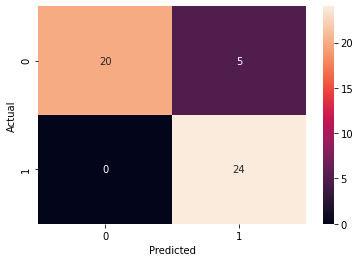

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        25
           1       0.83      1.00      0.91        24

    accuracy                           0.90        49
   macro avg       0.91      0.90      0.90        49
weighted avg       0.92      0.90      0.90        49

Model :KNN
Accuracy Score : 0.6122448979591837
f1 Score: 0.5581395348837209
Recall: 0.5
precision: 0.631578947368421
Confusion Matrix :


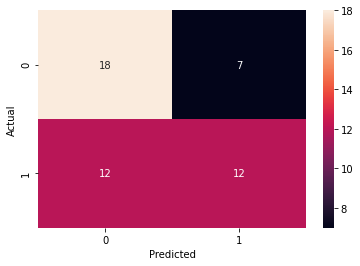

              precision    recall  f1-score   support

           0       0.60      0.72      0.65        25
           1       0.63      0.50      0.56        24

    accuracy                           0.61        49
   macro avg       0.62      0.61      0.61        49
weighted avg       0.62      0.61      0.61        49

Model :Decision_Tree
Accuracy Score : 0.6326530612244898
f1 Score: 0.5
Recall: 0.375
precision: 0.75
Confusion Matrix :


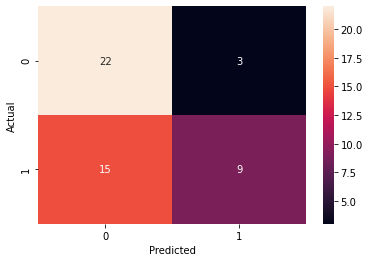

              precision    recall  f1-score   support

           0       0.59      0.88      0.71        25
           1       0.75      0.38      0.50        24

    accuracy                           0.63        49
   macro avg       0.67      0.63      0.60        49
weighted avg       0.67      0.63      0.61        49

Model :SVM
Accuracy Score : 0.5918367346938775
f1 Score: 0.7058823529411764
Recall: 1.0
precision: 0.5454545454545454
Confusion Matrix :


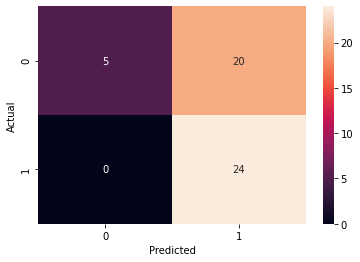

              precision    recall  f1-score   support

           0       1.00      0.20      0.33        25
           1       0.55      1.00      0.71        24

    accuracy                           0.59        49
   macro avg       0.77      0.60      0.52        49
weighted avg       0.78      0.59      0.52        49

Model :RF
Accuracy Score : 0.7346938775510204
f1 Score: 0.6829268292682927
Recall: 0.5833333333333334
precision: 0.8235294117647058
Confusion Matrix :


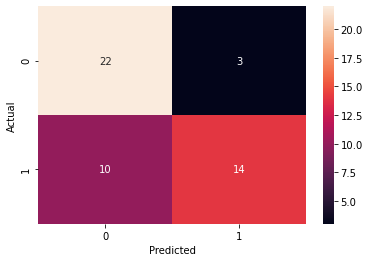

              precision    recall  f1-score   support

           0       0.69      0.88      0.77        25
           1       0.82      0.58      0.68        24

    accuracy                           0.73        49
   macro avg       0.76      0.73      0.73        49
weighted avg       0.75      0.73      0.73        49

[07:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Model :XGBoost
Accuracy Score : 0.7142857142857143
f1 Score: 0.6666666666666666
Recall: 0.5833333333333334
precision: 0.7777777777777778
Confusion Matrix :


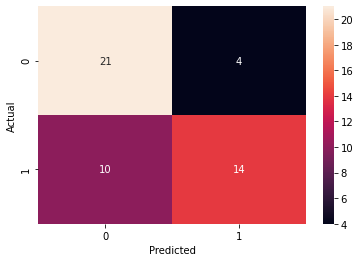

              precision    recall  f1-score   support

           0       0.68      0.84      0.75        25
           1       0.78      0.58      0.67        24

    accuracy                           0.71        49
   macro avg       0.73      0.71      0.71        49
weighted avg       0.73      0.71      0.71        49



In [35]:
results = []
names = []


for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    F1_score=f1_score(y_test, y_pred)
    Recall=recall_score(y_test, y_pred)
    Precision=precision_score(y_test, y_pred)
    results= pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
    print( "Model :" + name)
    print ('Accuracy Score :',accuracy_score(y_test,y_pred))
    print('f1 Score'+": " + str(F1_score))
    print('Recall' + ": " + str(Recall))
    print('precision' + ": " + str(Precision))
    print ('Confusion Matrix :')
    sns.heatmap(results, annot=True)
    plt.show() 
#     print(model.feature_importances_)
    print(classification_report(y_test,y_pred))

In [36]:
y_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0], dtype=int64)

In [37]:
np.array(y_test)

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0], dtype=int64)

# Logistic regression

In [38]:
logres = LogisticRegression()
logres.fit(X_train, y_train)
logres_y_pred = logres.predict(X_test)
logres.score(X_test,y_test)

0.8979591836734694

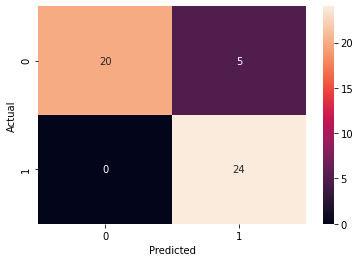

In [39]:
logres_confusion_matrix= pd.crosstab(y_test, logres_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
sns.heatmap(logres_confusion_matrix, annot=True)
plt.show()

In [40]:
logres_final_df = pd.DataFrame(data= np.array(y_test),columns=['Actual'])
logres_final_df['Prediction'] = np.array(logres_y_pred)
logres_final_df

Actual  Prediction
0        1           1
1        0           0
2        0           0
3        0           0
4        0           0
5        0           0
6        0           0
7        1           1
8        1           1
9        0           0
10       1           1
11       1           1
12       0           0
13       1           1
14       1           1
15       0           1
16       0           0
17       1           1
18       0           0
19       0           0
20       0           0
21       0           0
22       1           1
23       1           1
24       1           1
25       0           1
26       1           1
27       1           1
28       1           1
29       0           0
30       1           1
31       1           1
32       0           0
33       1           1
34       1           1
35       0           1
36       1           1
37       1           1
38       1           1
39       1           1
40       0           0
41       0           0
42       0           1
43       0           1
44       1           1
45       1           1
46       0           0
47       0           0
48       0           0

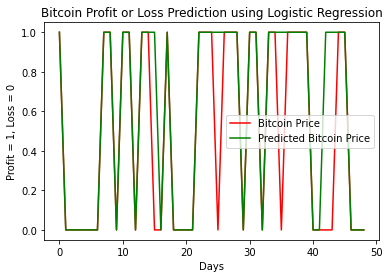

In [41]:
plt.plot(np.array(y_test), color = 'red', label = 'Bitcoin Price')
plt.plot(np.array(logres_y_pred), color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Profit or Loss Prediction using Logistic Regression')
plt.xlabel('Days')
plt.ylabel('Profit = 1, Loss = 0')
plt.legend()
plt.show()

# Grid search to find best parameter. cannot use this before of cross validation 

In [58]:
# model_params = {
#     'svm': {
#         'model': svm.SVC(gamma='auto'),
#         'params' : {
#             'C': [1,5,10],
#             'kernel': ['rbf','linear']
#         }  
#     },
#     'random_forest': {
#         'model': RandomForestClassifier(),
#         'params' : {
#             'n_estimators': [1,5,10]
#         }
#     },
#     'logistic_regression' : {
#         'model': LogisticRegression(),
#         'params': {
#             'C': [10,50,100]
#         }
#     },
#     'decision_tree' : {
#         'model': DecisionTreeClassifier(),
#         'params': {
#             'criterion': ['gini', 'entropy']
#         }
#     },
#     'GaussianNB': {
#         'model': GaussianNB(), 
#         'params': {}
#     },
#     'linear_regression': {
#         'model': linear_model.LinearRegression(),
#         'params': {}
#     }
 
# }

In [59]:
# scores = []

# for model_name, mp in model_params.items():
#     clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False) # need to remove this line, cann do cross validation for time series 
#     clf.fit(X_train,y_train)
#     scores.append({
#          'model': model_name,
#          'best_score': clf.best_score_,
#          'best_params': clf.best_params_
#      })
    
# model_score_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
# model_score_df

# Feature important 
check which feature have the most impact

In [42]:
logres.feature_importances_

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# Stacking 

In [62]:
BTC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 0 to 2711
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        2712 non-null   datetime64[ns]
 1   Open                        2712 non-null   float64       
 2   High                        2712 non-null   float64       
 3   Low                         2712 non-null   float64       
 4   Close                       2712 non-null   float64       
 5   Volume                      2712 non-null   int64         
 6   Profit_or_loss              2712 non-null   int64         
 7   previous_day_closing_price  2711 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 169.6 KB


In [63]:
X_columns = BTC_df[['Close', 'Volume']]
scaled_X_columns = scaler.fit_transform(X_columns)
X_1 = np.array(scaled_X_columns)
y_1 = np.array(y)

In [64]:
model1 = DecisionTreeClassifier()
model2 = RandomForestClassifier(n_estimators = 10)
model3 = XGBClassifier( n_estimators = 100, use_label_encoder= False)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
stackingmodel = StackingClassifier(
    classifiers = [model1, model2, model3],
    meta_classifier = lr)

Accuracy: 0.49 (+/- 0.03) [Decision Tree]
Accuracy: 0.49 (+/- 0.03) [Random Forest]
[20:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the 

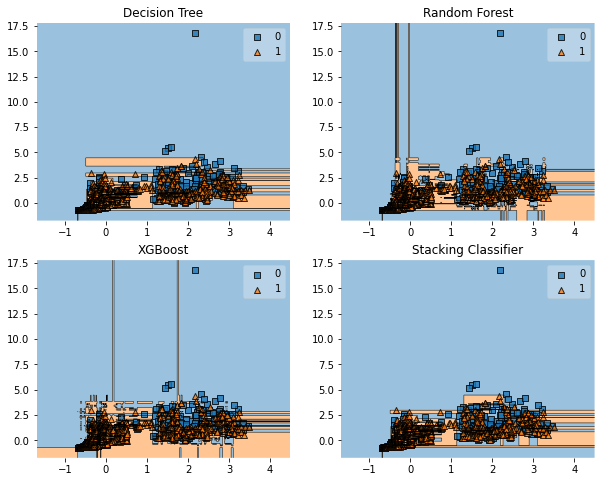

In [65]:

label = ['Decision Tree', 'Random Forest', 'XGBoost', 'Stacking Classifier']
model_list = [model1, model2, model3, stackingmodel]
    
fig = plt.figure(figsize = (10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0, 1], repeat = 2)

model_cv_mean = []
model_cv_std = []
for model, label, grd in zip(model_list, label, grid):
        
    scores = cross_val_score(model,X_1, y_1, cv = 5, scoring = 'accuracy') #- time series should not do crossval
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    model_cv_mean.append(scores.mean())
    model_cv_std.append(scores.std())
        
    model.fit(X_1, y_1)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X_1, y = y_1, clf = model)
    plt.title(label)

plt.show()

# model_score_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
# model_score_df

# Plot prediction graph, Try using closing price as Y and use regression model to train the data 
# plot the volumn chart out to see whether there is increasing trend of trading bitcoin
## Base on the volumn check out the news in the market to see what is pushing the price up. 

